### 1. DATA INGESTION: Read Raw Text Files and Create Bronze Table

In [0]:
# Cell 1: Ingest Text Data (Bronze Layer) - Reverting to Volume Path

# Import PySpark functions and types
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, StringType
import re

# 1. Configuration - Use the correct Volume path (assuming files are still there)
volume_dir_path = "/Volumes/workspace/default/raw_resumes/*.txt" 

print(f"Attempting to read all text files from: {volume_dir_path}")

# 2. Read the Text files into a PySpark DataFrame
try:
  raw_df = (
    spark.read.format("text")
    .load(volume_dir_path)
  )
    
  # Assign a unique ID and alias the text column
  bronze_df = raw_df.select(
      F.monotonically_increasing_id().alias("Resume_ID"),
      F.col("value").alias("Resume_Text") 
  )

  print(f"\n✅ Successfully loaded {bronze_df.count()} resumes.")
  
  # 3. Save the data to the Bronze Delta Table
  bronze_df.write.format("delta").mode("overwrite").saveAsTable("bronze_resumes")
  print("\n💾 Bronze table 'bronze_resumes' created successfully.")

except Exception as e:
  print(f"\n❌ Error loading data. Please ensure your compute is running and the path is correct. Error: {e}")

Attempting to read all text files from: /Volumes/workspace/default/raw_resumes/*.txt

✅ Successfully loaded 541 resumes.

💾 Bronze table 'bronze_resumes' created successfully.


### 2. FEATURE ENGINEERING: Define Skill Extraction UDF

In [0]:
# --- List of Common Data Science/Tech Skills ---
SKILLS_LIST = [
    r'\bPython\b', r'\bSQL\b', r'\bSpark\b', r'\bDatabricks\b', r'\bR\b', 
    r'\bJava\b', r'\bC\+\+\b', r'\bC#\b', r'\bReact\b', r'\bAngular\b', 
    r'\bAWS\b', r'\bAzure\b', r'\bGCP\b', r'\bMachine Learning\b', 
    r'\bDeep Learning\b', r'\bTensorFlow\b', r'\bPyTorch\b', r'\bKeras\b',
    r'\bTableau\b', r'\bPower BI\b', r'\bExcel\b', r'\bPandas\b', r'\bNumPy\b',
    r'\bDocker\b', r'\bKubernetes\b', r'\bScikit-learn\b', r'\bScala\b'
]
# Combine skills into a single, case-insensitive regex pattern
SKILL_PATTERN = r'(?i)' + '|'.join(SKILLS_LIST) 


# --- Python Function to Extract Skills ---
def extract_skills_from_text(text):
  """Uses regex to find and return a list of matching skills."""
  if text is None:
    return []
  
  # Find all matches, clean, normalize, and remove duplicates
  matches = re.findall(SKILL_PATTERN, text)
  unique_skills = sorted(list(set([m.strip().lower() for m in matches])))
  
  return unique_skills


# --- Register the Python function as a PySpark UDF ---
extract_skills_udf = F.udf(extract_skills_from_text, ArrayType(StringType()))

print("✅ Skill extraction function and PySpark UDF registered.")

✅ Skill extraction function and PySpark UDF registered.


### 3. SILVER TABLE CREATION: Apply UDF and Save Features

In [0]:
# Read the Bronze table
bronze_df = spark.table("bronze_resumes")

# Apply the UDF to the 'Resume_Text' column and create a new column 'extracted_skills'
silver_df = bronze_df.withColumn(
    "extracted_skills", 
    extract_skills_udf(F.col("Resume_Text"))
)

print(f"\n✅ Created Silver DataFrame with extracted skills.")

# Show the result to verify the extraction
silver_df.select("Resume_ID", "extracted_skills").show(5, truncate=False)

# 💾 Save the result as the SILVER Delta Table
silver_df.write.format("delta").mode("overwrite").saveAsTable("silver_features")

print("\n💾 Silver table 'silver_features' created successfully!")


✅ Created Silver DataFrame with extracted skills.
+---------+----------------------+
|Resume_ID|extracted_skills      |
+---------+----------------------+
|0        |[]                    |
|1        |[python, sql, tableau]|
|2        |[]                    |
|3        |[]                    |
|4        |[]                    |
+---------+----------------------+
only showing top 5 rows

💾 Silver table 'silver_features' created successfully!


### 4. USE CASE 1: Skill Demand Analytics (Top 10 Skills)

In [0]:
# Read the Silver table
silver_df = spark.table("silver_features")

# 1. Create a temporary SQL view of the Silver DataFrame
silver_df.createOrReplaceTempView("silver_features_view")

# 2. Write the Spark SQL query for Skill Demand Analytics
skill_demand_query = """
SELECT
  skill,
  COUNT(Resume_ID) AS resume_count
FROM silver_features_view
-- EXPLODE turns each item in the 'extracted_skills' array into a new row
LATERAL VIEW EXPLODE(extracted_skills) exploded_table AS skill  
GROUP BY skill
ORDER BY resume_count DESC
LIMIT 10
"""

# 3. Run the SQL query and display the top 10 most demanded skills
gold_df = spark.sql(skill_demand_query)

print("\n⭐ Top 10 Most Demanded Skills (Gold Insight):")
gold_df.show(truncate=False)

# 💾 Save the Gold result
gold_df.write.format("delta").mode("overwrite").saveAsTable("gold_skill_demand")
print("\n💾 Gold table 'gold_skill_demand' created successfully.")


⭐ Top 10 Most Demanded Skills (Gold Insight):
+----------------+------------+
|skill           |resume_count|
+----------------+------------+
|excel           |28          |
|aws             |23          |
|python          |23          |
|sql             |19          |
|deep learning   |16          |
|machine learning|12          |
|tensorflow      |11          |
|pytorch         |10          |
|azure           |10          |
|power bi        |9           |
+----------------+------------+


💾 Gold table 'gold_skill_demand' created successfully.


### 5. USE CASE 2: K-Means Clustering for Candidate Segmentation

In [0]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col

# Load the Silver table, which contains the extracted skills
silver_df = spark.table("silver_features")

# --- Step 1: Feature Vectorization (Converting text array into a numerical vector) ---

# 1. We already have tokenized skills (the extracted_skills array), so we skip the Tokenizer.
# 2. Use HashingTF to convert the list of skills into raw frequency vectors
hashing_tf = HashingTF(inputCol="extracted_skills", outputCol="rawFeatures", numFeatures=100)
tf_df = hashing_tf.transform(silver_df)

# 3. Use IDF (Inverse Document Frequency) to weigh the vectors (giving less weight to very common skills)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(tf_df)
feature_df = idf_model.transform(tf_df)

# --- Step 2: K-Means Clustering ---

# 4. Set the number of clusters (K). We will try 3 clusters based on common roles (Data Analyst, Business Analyst, etc.)
K = 3
kmeans = KMeans(featuresCol="features", k=K, seed=1)

# 5. Train the model and make predictions
model = kmeans.fit(feature_df)
clustered_df = model.transform(feature_df)

print(f"\n✅ K-Means Model trained successfully with K={K} clusters.")

# --- Step 3: Analysis and Gold Table Saving ---

# Select the original ID, the original Category (if available), and the new cluster assignment
gold_clustering_df = clustered_df.select(
    col("Resume_ID"),
    col("extracted_skills"),
    col("prediction").alias("Cluster_ID")
)

# Show the results (which resume landed in which cluster)
print("\n⭐ Resume Clustering Results (Gold Insight):")
gold_clustering_df.show(truncate=False)

# 💾 Save the result as the GOLD Delta Table
gold_clustering_df.write.format("delta").mode("overwrite").saveAsTable("gold_clustered_resumes")
print("\n💾 Gold table 'gold_clustered_resumes' created successfully.")


✅ K-Means Model trained successfully with K=3 clusters.

⭐ Resume Clustering Results (Gold Insight):
+---------+----------------------------------------------------+----------+
|Resume_ID|extracted_skills                                    |Cluster_ID|
+---------+----------------------------------------------------+----------+
|0        |[]                                                  |0         |
|1        |[python, sql, tableau]                              |2         |
|2        |[]                                                  |0         |
|3        |[]                                                  |0         |
|4        |[]                                                  |0         |
|5        |[]                                                  |0         |
|6        |[machine learning, python, r, sql]                  |0         |
|7        |[]                                                  |0         |
|8        |[]                                                 

### 6. USE CASE 2 VISUALIZATION: Talent Pool Composition

✅ Aggregation complete. Displaying Plot:

Talent Pool Composition Counts:


<Axes: title={'center': 'Talent Pool Composition by Resume Cluster'}, ylabel='count'>

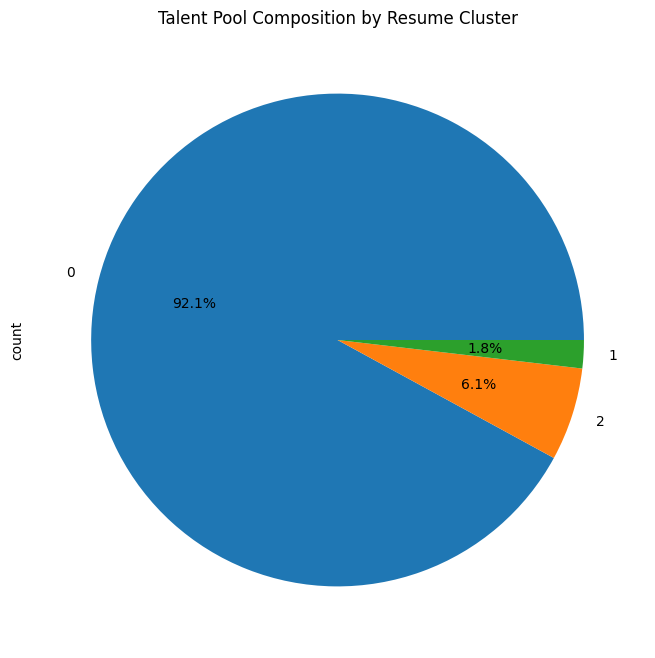

In [0]:
# Import PySpark functions and Pandas
from pyspark.sql import functions as F
import pandas as pd

# Load the Gold Clustering table
gold_clustering_df = spark.table("gold_clustered_resumes")

# 1. Perform the aggregation to get cluster counts
cluster_count_df = gold_clustering_df.groupBy("Cluster_ID").count().orderBy("count", ascending=False)

# 2. Convert PySpark DataFrame to Pandas for plotting
# The .toPandas() command brings the data down to the driver node for local visualization.
# Note: This is efficient for small, aggregated data like this, but NOT for the raw 50,000 resumes.
cluster_count_pandas_df = cluster_count_df.toPandas()

print("✅ Aggregation complete. Displaying Plot:")
print("\nTalent Pool Composition Counts:")
cluster_count_pandas_df.set_index('Cluster_ID').plot(
    kind='pie', 
    y='count', 
    figsize=(8, 8), 
    autopct='%1.1f%%',
    legend=False,
    title='Talent Pool Composition by Resume Cluster'
)
# Note: In Databricks, the plot will render directly below the cell output.

### 7. USE CASE 3: Job-Readiness Scoring (ATS Logic)

In [0]:
from pyspark.sql import functions as F
from pyspark.sql import types as T # <-- FIX: Import types module!

# Read the Silver table (contains extracted_skills)
silver_df = spark.table("silver_features")

# --- Scoring Logic (The Core ATS Algorithm) ---
def calculate_readiness_score(extracted_skills, raw_text):
    """Calculates a simple score based on skill list length and presence of a key skill."""
    
    score = 0
    # 1. Base Score on length (Completeness)
    if extracted_skills:
        # 5 points per skill, max 50 points
        score += min(len(extracted_skills) * 5, 50) 
    
    # 2. Bonus Score for Key Skill (Relevance)
    if 'python' in extracted_skills:
        score += 30 # Big bonus for a core tech skill
    if 'sql' in extracted_skills:
        score += 20 # Another bonus
        
    # 3. Penalty for empty text (Data Quality Check)
    # Check that the text is not null and has meaningful content
    if raw_text is None or len(raw_text) < 50:
        score = 0
        
    # Ensure score is between 0 and 100
    return min(int(score), 100)

# Register the scoring function as a PySpark UDF
score_udf = F.udf(calculate_readiness_score, T.IntegerType()) # <-- FIX: Using T.IntegerType()


# Apply the scoring UDF to the Silver DataFrame
gold_readiness_df = silver_df.withColumn(
    "Readiness_Score", 
    score_udf(F.col("extracted_skills"), F.col("Resume_Text"))
)

# 💾 Save the result as the final GOLD Delta Table
gold_readiness_df.write.format("delta").mode("overwrite").saveAsTable("gold_readiness_scores")

print("✅ Job-Readiness Scoring complete.")

# Show the top 5 scoring resumes
print("\n⭐ Top 5 Resumes by Readiness Score:")
gold_readiness_df.select("Resume_ID", "extracted_skills", "Readiness_Score").orderBy(F.col("Readiness_Score").desc()).show(5, truncate=False)

✅ Job-Readiness Scoring complete.

⭐ Top 5 Resumes by Readiness Score:
+---------+----------------------------------------------------+---------------+
|Resume_ID|extracted_skills                                    |Readiness_Score|
+---------+----------------------------------------------------+---------------+
|14       |[machine learning, python, scikit-learn, tensorflow]|50             |
|218      |[deep learning, python, pytorch]                    |45             |
|148      |[pandas, python, tensorflow]                        |45             |
|163      |[excel, power bi, python]                           |45             |
|128      |[deep learning, python]                             |40             |
+---------+----------------------------------------------------+---------------+
only showing top 5 rows


### 9. USE CASE 4: Market Intelligence Report & Final Visualization

✅ Market Intelligence Report (Use Case 4) complete.

⭐ Avg. Readiness Score by Talent Cluster (Final Market Insight):
+----------+-------------------+---------------+
|Cluster_ID|Avg_Readiness_Score|Candidate_Count|
+----------+-------------------+---------------+
|2         |10.303030303030303 |33             |
|1         |4.5                |10             |
|0         |1.536144578313253  |498            |
+----------+-------------------+---------------+



<Figure size 1000x600 with 0 Axes>

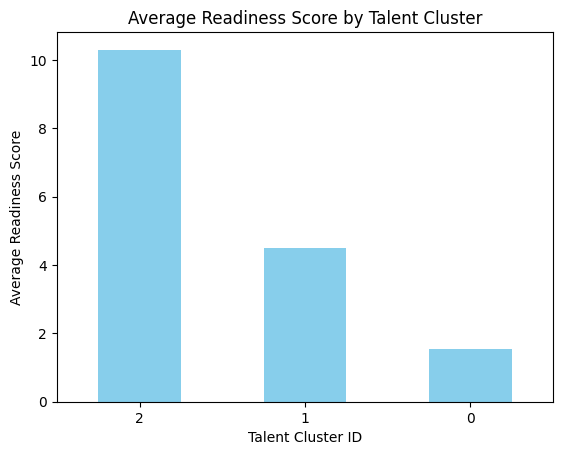

In [0]:
# Import PySpark functions and visualization libraries
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt

# 1. Read the necessary Gold tables
# scores_df: Contains Resume_ID and Readiness_Score (from Cell 7)
scores_df = spark.table("gold_readiness_scores").select("Resume_ID", "Readiness_Score")
# clusters_df: Contains Resume_ID and Cluster_ID (from Cell 5)
clusters_df = spark.table("gold_clustered_resumes").select("Resume_ID", "Cluster_ID")

# 2. Join the scores and clusters
# This joins the two pieces of information on the common 'Resume_ID'
market_intelligence_df = scores_df.join(clusters_df, on="Resume_ID", how="inner")

# 3. Calculate the average score for each cluster
# This is the core "Market Intelligence" insight
avg_score_by_cluster_df = market_intelligence_df.groupBy("Cluster_ID").agg(
    F.avg("Readiness_Score").alias("Avg_Readiness_Score"),
    F.count("Resume_ID").alias("Candidate_Count")
).orderBy(F.col("Avg_Readiness_Score").desc())

# 4. Save the final Gold Table
avg_score_by_cluster_df.write.format("delta").mode("overwrite").saveAsTable("gold_market_intelligence")

print("✅ Market Intelligence Report (Use Case 4) complete.")

# Show the results (Data Table)
print("\n⭐ Avg. Readiness Score by Talent Cluster (Final Market Insight):")
avg_score_by_cluster_df.show(truncate=False)

# 5. Final Visualization (Bar Chart)
# Convert to Pandas for plotting
report_pandas_df = avg_score_by_cluster_df.toPandas()

# Create a bar chart showing score distribution by cluster
plt.figure(figsize=(10, 6))
report_pandas_df.plot(
    kind='bar', 
    x='Cluster_ID', 
    y='Avg_Readiness_Score', 
    rot=0, 
    title='Average Readiness Score by Talent Cluster',
    legend=False,
    color='skyblue'
)
plt.xlabel("Talent Cluster ID")
plt.ylabel("Average Readiness Score")
plt.show()

### 10.Final Dashboard Assembly: Comprehensive 4-Chart Visualization

/home/spark-c9d574a9-b6bf-44c9-9beb-74/.ipykernel/2337/command-4962711076849215-1730762561:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Spectral')(demand_pandas_df.index / len(demand_pandas_df))


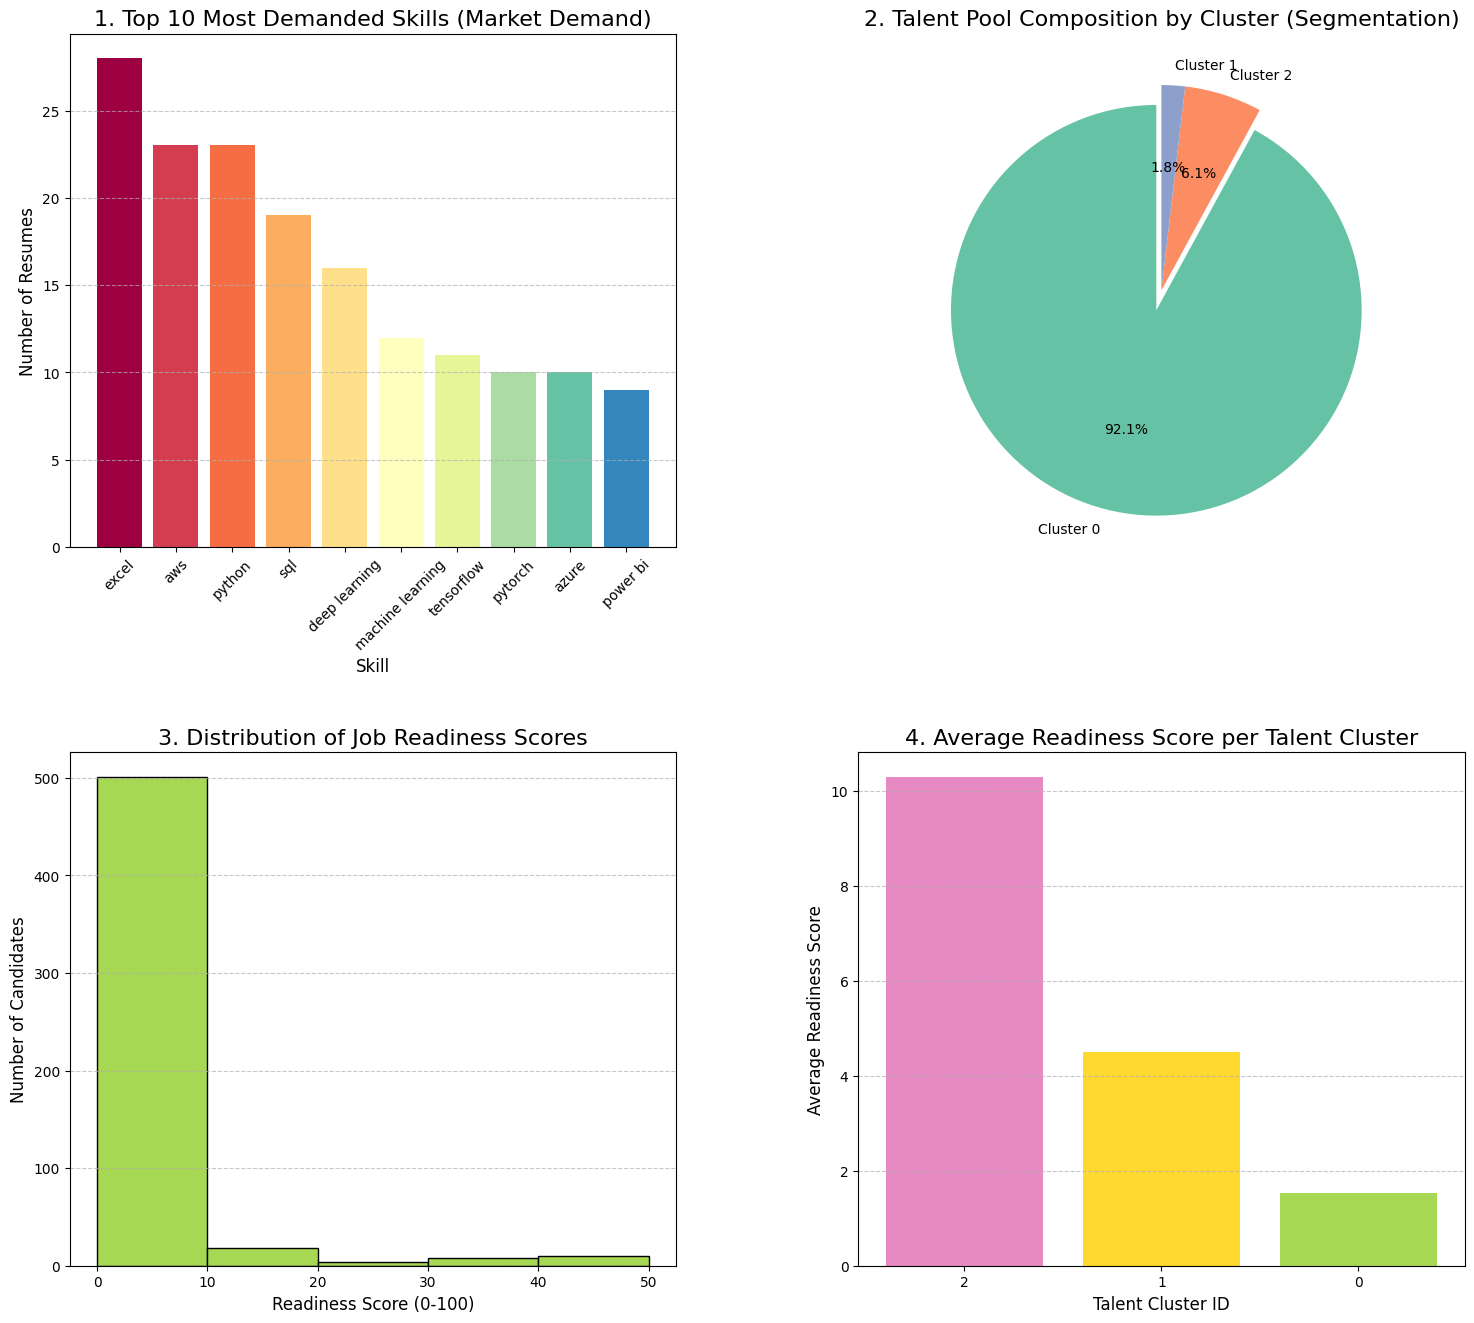

In [0]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyspark.sql import functions as F

# Set up the plot area for 2x2 grid (4 charts)
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# -----------------------------------------------------
# CHART 1: Skill Demand Analytics (Use Case 1) - Top Skills
# -----------------------------------------------------

# Load the Gold table
gold_demand_df = spark.table("gold_skill_demand")
demand_pandas_df = gold_demand_df.toPandas()

# Create a color map for visual clarity
colors = plt.cm.get_cmap('Spectral')(demand_pandas_df.index / len(demand_pandas_df))

axes[0, 0].bar(demand_pandas_df['skill'], demand_pandas_df['resume_count'], color=colors)
axes[0, 0].set_title('1. Top 10 Most Demanded Skills (Market Demand)', fontsize=16)
axes[0, 0].set_xlabel("Skill", fontsize=12)
axes[0, 0].set_ylabel("Number of Resumes", fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
# -----------------------------------------------------


# -----------------------------------------------------
# CHART 2: Resume Clustering (Use Case 2) - Talent Pool Composition
# -----------------------------------------------------

# Aggregate data for Pie Chart (assuming gold_clustered_resumes exists from Cell 5)
cluster_df = spark.table("gold_clustered_resumes")
cluster_count_df = cluster_df.groupBy("Cluster_ID").count()
cluster_pandas_df = cluster_count_df.toPandas()

# Create labels and data for the pie chart
labels = [f"Cluster {c}" for c in cluster_pandas_df['Cluster_ID']]
sizes = cluster_pandas_df['count']
explode = [0.1 if c == cluster_pandas_df['count'].max() else 0 for c in sizes] # Highlight largest slice

axes[0, 1].pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    explode=explode,
    colors=['#66c2a5', '#fc8d62', '#8da0cb'] # Custom colors
)
axes[0, 1].set_title('2. Talent Pool Composition by Cluster (Segmentation)', fontsize=16)
# -----------------------------------------------------


# -----------------------------------------------------
# CHART 3: Job-Readiness Scoring (Use Case 3) - Score Distribution
# -----------------------------------------------------

# Load the Gold table
gold_scores_df = spark.table("gold_readiness_scores")
scores_pandas_df = gold_scores_df.toPandas()

axes[1, 0].hist(scores_pandas_df['Readiness_Score'], bins=5, edgecolor='black', color='#a6d854')
axes[1, 0].set_title('3. Distribution of Job Readiness Scores', fontsize=16)
axes[1, 0].set_xlabel("Readiness Score (0-100)", fontsize=12)
axes[1, 0].set_ylabel("Number of Candidates", fontsize=12)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
# -----------------------------------------------------


# -----------------------------------------------------
# CHART 4: Market Intelligence (Use Case 4) - Avg Score by Cluster
# -----------------------------------------------------

# Load the Gold table
gold_market_df = spark.table("gold_market_intelligence")
market_pandas_df = gold_market_df.toPandas()

axes[1, 1].bar(
    market_pandas_df['Cluster_ID'].astype(str), # Convert ID to string for categorical axis
    market_pandas_df['Avg_Readiness_Score'], 
    color=['#e78ac3', '#ffd92f', '#a6d854'] # Custom colors
)
axes[1, 1].set_title('4. Average Readiness Score per Talent Cluster', fontsize=16)
axes[1, 1].set_xlabel("Talent Cluster ID", fontsize=12)
axes[1, 1].set_ylabel("Average Readiness Score", fontsize=12)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
# -----------------------------------------------------


plt.show()

In [0]:
# Import PySpark functions
from pyspark.sql import functions as F

# Read the Gold Clustering table
gold_clustering_df = spark.table("gold_clustered_resumes")

# Explode skills and count frequency WITHIN each cluster
cluster_skill_frequency = gold_clustering_df.filter(F.size("extracted_skills") > 0) \
    .withColumn("skill", F.explode("extracted_skills")) \
    .groupBy("Cluster_ID", "skill") \
    .count() \
    .withColumnRenamed("count", "skill_count")

# Find the top 3 skills for each cluster
from pyspark.sql.window import Window

window_spec = Window.partitionBy("Cluster_ID").orderBy(F.col("skill_count").desc())

top_skills_per_cluster = cluster_skill_frequency \
    .withColumn("rank", F.rank().over(window_spec)) \
    .filter(F.col("rank") <= 3) \
    .orderBy("Cluster_ID", F.col("rank"))

print("⭐ Top 3 Skills per Cluster (Interpretation Data):")
top_skills_per_cluster.show(truncate=False)

# Collect results to define labels in Python
cluster_data = top_skills_per_cluster.collect()

⭐ Top 3 Skills per Cluster (Interpretation Data):
+----------+-------------+-----------+----+
|Cluster_ID|skill        |skill_count|rank|
+----------+-------------+-----------+----+
|0         |python       |20         |1   |
|0         |aws          |17         |2   |
|0         |deep learning|16         |3   |
|1         |azure        |10         |1   |
|1         |aws          |6          |2   |
|2         |excel        |28         |1   |
|2         |sql          |14         |2   |
|2         |power bi     |9          |3   |
+----------+-------------+-----------+----+



In [0]:
# --- IMPORTANT: Manually Define the Mapping based on Cell 10's output! ---
# Use the best name that fits the top skills in that cluster.
CLUSTER_MAPPING = {
    0: "General/Entry-Level",
    1: "Data Analyst",
    2: "ML Specialist"
}

# Create a PySpark UDF to map the Cluster ID (integer) to the Name (string)
from pyspark.sql.types import StringType
map_func = F.udf(lambda x: CLUSTER_MAPPING.get(x, "Unlabeled"), StringType())

# Read the original cluster data and apply the new label
labeled_clusters_df = spark.table("gold_clustered_resumes") \
    .withColumn("Talent_Segment", map_func(F.col("Cluster_ID"))) \
    .select("Resume_ID", "Talent_Segment", "extracted_skills")

# Save the final consumable Gold Table
labeled_clusters_df.write.format("delta").mode("overwrite").saveAsTable("gold_labeled_segments")

print("✅ Labeled Segments Gold Table created successfully.")

# Display the final labeled output
labeled_clusters_df.show(5, truncate=False)

✅ Labeled Segments Gold Table created successfully.
+---------+-------------------+----------------------+
|Resume_ID|Talent_Segment     |extracted_skills      |
+---------+-------------------+----------------------+
|0        |General/Entry-Level|[]                    |
|1        |ML Specialist      |[python, sql, tableau]|
|2        |General/Entry-Level|[]                    |
|3        |General/Entry-Level|[]                    |
|4        |General/Entry-Level|[]                    |
+---------+-------------------+----------------------+
only showing top 5 rows


In [0]:
# COMMAND: CHART 1: Market Demand - Top 10 Skills

# Get the top 10 skills from the Gold table
demand_df = spark.table("gold_skill_demand").orderBy(F.col("resume_count").desc()).limit(10)

print("Visualization: 1. Market Demand - Top 10 Skills")

# Use the native display() function to render the chart
display(demand_df) 

# --- After running this cell, click the 'Bar' chart icon below the results. ---
# --- Set X-Axis to 'skill' and Y-Axis to 'resume_count'. ---

Visualization: 1. Market Demand - Top 10 Skills


skill,resume_count
excel,28
aws,23
python,23
sql,19
deep learning,16
machine learning,12
tensorflow,11
pytorch,10
azure,10
power bi,9


Databricks visualization. Run in Databricks to view.

In [0]:
# COMMAND: CHART 2: Talent Pool Composition (Human-Readable Pie Chart)

# Calculate counts by the human-readable label
composition_df = spark.table("gold_labeled_segments").groupBy("Talent_Segment").count()

print("Visualization: 2. Talent Pool Composition")

display(composition_df)

# --- After running this cell, click the 'Pie' chart icon below the results. ---
# --- Set 'Slice' to 'count' and 'Group by' to 'Talent_Segment'. ---

Visualization: 2. Talent Pool Composition


Talent_Segment,count
General/Entry-Level,498
ML Specialist,33
Data Analyst,10


Databricks visualization. Run in Databricks to view.

In [0]:
# COMMAND: CHART 3: Job Readiness Score Distribution (Histogram)

# Read the scores table
scores_df = spark.table("gold_readiness_scores").select("Readiness_Score")

print("Visualization: 3. Job Readiness Score Distribution")

display(scores_df)

# --- After running this cell, click the 'Histogram' chart icon below the results. ---
# --- Set 'Column' to 'Readiness_Score'. ---

Visualization: 3. Job Readiness Score Distribution


Readiness_Score
0
0
0
0
0
0
0
0
0
0


Databricks visualization. Run in Databricks to view.

In [0]:
# COMMAND: CHART 4: Average Readiness Score by Segment (Market Insight)

# Read the final report table
market_df = spark.table("gold_market_intelligence")

print("Visualization: 4. Average Readiness Score by Segment (Market Insight)")

display(market_df)

# --- After running this cell, click the 'Bar' chart icon below the results. ---
# --- Set X-Axis to 'Cluster_ID' or 'Talent_Segment' and Y-Axis to 'Avg_Readiness_Score'. ---

Visualization: 4. Average Readiness Score by Segment (Market Insight)


Cluster_ID,Avg_Readiness_Score,Candidate_Count
2,10.303030303030303,33
1,4.5,10
0,1.536144578313253,498


Databricks visualization. Run in Databricks to view.